In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import dask
import dask.array as da
import dask.dataframe as dd

In [2]:
%%time
import polars as pl
train_series = (pl.scan_parquet('train_series.parquet')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: user 50.7 s, sys: 12 s, total: 1min 2s
Wall time: 54.1 s


In [3]:
train_series.head(10)

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14 15:30:00,2.6367,0.0217
1,038441c925bb,1,2018-08-14 15:30:05,2.6368,0.0215
2,038441c925bb,2,2018-08-14 15:30:10,2.6370,0.0216
3,038441c925bb,3,2018-08-14 15:30:15,2.6368,0.0213
4,038441c925bb,4,2018-08-14 15:30:20,2.6368,0.0215
5,038441c925bb,5,2018-08-14 15:30:25,2.6367,0.0217
6,038441c925bb,6,2018-08-14 15:30:30,2.6367,0.0217
7,038441c925bb,7,2018-08-14 15:30:35,2.6367,0.0218
8,038441c925bb,8,2018-08-14 15:30:40,2.7980,0.0223
9,038441c925bb,9,2018-08-14 15:30:45,3.0847,0.0217


In [4]:
from pandas.api.types import is_datetime64_ns_dtype
import gc

import warnings
warnings.filterwarnings("ignore")

def reduce_mem_usage(df):
    
    """ 
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not is_datetime64_ns_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        

    df['series_id'] = df['series_id'].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f'Decreased by {decrease:.2f}%')
    
    return df

In [5]:
train_series = reduce_mem_usage(train_series)

Memory usage of dataframe is 3416.54 MB
Memory usage after optimization is: 2684.43 MB
Decreased by 21.43%


In [6]:
train_events = (pl.scan_csv('train_events.csv')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

In [7]:
train_events.head(10)

,series_id,night,event,step,timestamp,year,month,day,hour
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018.0,8.0,14.0,22.0
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018.0,8.0,15.0,6.0
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018.0,8.0,15.0,19.0
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00,2018.0,8.0,16.0,5.0
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00,2018.0,8.0,16.0,23.0
5,038441c925bb,3,wakeup,44400.0,2018-08-17 05:10:00,2018.0,8.0,17.0,5.0
6,038441c925bb,4,onset,57240.0,2018-08-17 23:00:00,2018.0,8.0,17.0,23.0
7,038441c925bb,4,wakeup,62856.0,2018-08-18 06:48:00,2018.0,8.0,18.0,6.0
8,038441c925bb,5,onset,NaN,NaT,NaN,NaN,NaN,NaN
9,038441c925bb,5,wakeup,NaN,NaT,NaN,NaN,NaN,NaN


In [17]:
train_events["awake"] = train_events["event"].replace({"onset":1,"wakeup":0})

train = pd.merge(train_series, train_events[['step','awake']], on='step', how='left')

In [ ]:
train_events.head(10)

In [16]:
train_sorted = train.sort_values(by='step')
train_sorted.head(10) 

,series_id,step,timestamp,anglez,enmo,awake
0,038441c925bb,0.0,2018-08-14 15:30:00,2.636700,0.0217,NaN
39358996,51b23d177971,0.0,2017-09-06 12:15:00,-49.734798,0.0362,NaN
125525697,fa149c3c4bde,0.0,2018-08-30 19:00:00,26.329901,0.0750,NaN
37447368,4ac356361be9,0.0,2018-01-19 16:15:00,-85.568398,0.0401,NaN
16297637,1955d568d987,0.0,2019-02-01 11:15:00,-3.485300,0.0406,NaN
112726651,e30cb792a2bc,0.0,2017-10-10 16:45:00,-88.679703,0.0100,NaN
17244569,1c7c0bad1263,0.0,2018-12-12 15:45:00,-80.277000,0.0000,NaN
111889189,e2a849d283c0,0.0,2018-05-17 18:15:00,51.293098,0.0651,NaN
93102114,c7b1283bb7eb,0.0,2018-10-10 12:45:00,-86.387901,0.0021,NaN
42122016,599ca4ed791b,0.0,2019-02-07 16:00:00,-89.682198,0.0000,NaN


In [17]:
train_series.head(10)

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0.0,2018-08-14 15:30:00,2.6367,0.0217
1,038441c925bb,1.0,2018-08-14 15:30:05,2.6368,0.0215
2,038441c925bb,2.0,2018-08-14 15:30:10,2.6370,0.0216
3,038441c925bb,3.0,2018-08-14 15:30:15,2.6368,0.0213
4,038441c925bb,4.0,2018-08-14 15:30:20,2.6368,0.0215
5,038441c925bb,5.0,2018-08-14 15:30:25,2.6367,0.0217
6,038441c925bb,6.0,2018-08-14 15:30:30,2.6367,0.0217
7,038441c925bb,7.0,2018-08-14 15:30:35,2.6367,0.0218
8,038441c925bb,8.0,2018-08-14 15:30:40,2.7980,0.0223
9,038441c925bb,9.0,2018-08-14 15:30:45,3.0847,0.0217


In [18]:
train.head(10)

,series_id,step,timestamp,anglez,enmo,awake
0,038441c925bb,0.0,2018-08-14 15:30:00,2.6367,0.0217,NaN
1,038441c925bb,1.0,2018-08-14 15:30:05,2.6368,0.0215,NaN
2,038441c925bb,2.0,2018-08-14 15:30:10,2.6370,0.0216,NaN
3,038441c925bb,3.0,2018-08-14 15:30:15,2.6368,0.0213,NaN
4,038441c925bb,4.0,2018-08-14 15:30:20,2.6368,0.0215,NaN
5,038441c925bb,5.0,2018-08-14 15:30:25,2.6367,0.0217,NaN
6,038441c925bb,6.0,2018-08-14 15:30:30,2.6367,0.0217,NaN
7,038441c925bb,7.0,2018-08-14 15:30:35,2.6367,0.0218,NaN
8,038441c925bb,8.0,2018-08-14 15:30:40,2.7980,0.0223,NaN
9,038441c925bb,9.0,2018-08-14 15:30:45,3.0847,0.0217,NaN


In [55]:
series_has_NaN = train.groupby('series_id')['awake'].apply(lambda x: x.isnull().any())
series_has_NaN.value_counts()

True    277
Name: awake, dtype: int64

In [9]:
series_has_NaN = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
series_has_NaN.value_counts()

True     240
False     37
Name: step, dtype: int64

In [13]:
# series with na
NaN_series = series_has_NaN[series_has_NaN].index.tolist()

In [26]:
filtered_df = train_events[train_events['series_id'] == '038441c925bb']

In [27]:
filtered_df.head(100)

,series_id,night,event,step,timestamp,year,month,day,hour,awake
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018.0,8.0,14.0,22.0,1
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018.0,8.0,15.0,6.0,0
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018.0,8.0,15.0,19.0,1
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00,2018.0,8.0,16.0,5.0,0
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00,2018.0,8.0,16.0,23.0,1
5,038441c925bb,3,wakeup,44400.0,2018-08-17 05:10:00,2018.0,8.0,17.0,5.0,0
6,038441c925bb,4,onset,57240.0,2018-08-17 23:00:00,2018.0,8.0,17.0,23.0,1
7,038441c925bb,4,wakeup,62856.0,2018-08-18 06:48:00,2018.0,8.0,18.0,6.0,0
8,038441c925bb,5,onset,NaN,NaT,NaN,NaN,NaN,NaN,1
9,038441c925bb,5,wakeup,NaN,NaT,NaN,NaN,NaN,NaN,0


In [28]:
# Create a dictionary to store missing value ratio tables for each series
missing_ratio_tables = {}

# Loop through each series_id and calculate the missing value ratio table
for series_id in NaN_series:
    # Filter the DataFrame for the current series_id
    filtered_df = train_events[train_events['series_id'] == series_id]
    
    # Calculate the missing value ratio for each column
    missing_ratio = filtered_df.isnull().mean()
    
    # Add the missing value ratio table to the dictionary
    missing_ratio_tables[series_id] = missing_ratio

# Create a DataFrame from the dictionary
missing_ratio_df = pd.DataFrame(missing_ratio_tables)

# Transpose the DataFrame for a more readable format
missing_ratio_df = missing_ratio_df.T

# Set options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Print the missing value ratio table for each series
print(missing_ratio_df)

              series_id  night  event      step  timestamp      year  \
038441c925bb        0.0    0.0    0.0  0.173913   0.173913  0.173913   
03d92c9f6f8a        0.0    0.0    0.0  0.783784   0.783784  0.783784   
0402a003dae9        0.0    0.0    0.0  0.250000   0.250000  0.250000   
04f547b8017d        0.0    0.0    0.0  0.432432   0.432432  0.432432   
05e1944c3818        0.0    0.0    0.0  0.125000   0.125000  0.125000   
062cae666e2a        0.0    0.0    0.0  0.884615   0.884615  0.884615   
062dbd4c95e6        0.0    0.0    0.0  0.681818   0.681818  0.681818   
0cd1e3d0ed95        0.0    0.0    0.0  0.714286   0.714286  0.714286   
0ce74d6d2106        0.0    0.0    0.0  0.100000   0.100000  0.100000   
0d0ad1e77851        0.0    0.0    0.0  0.166667   0.166667  0.166667   
0dee4fda51c3        0.0    0.0    0.0  0.166667   0.166667  0.166667   
0ec9fc461819        0.0    0.0    0.0  0.090909   0.090909  0.090909   
0ef7d94fde99        0.0    0.0    0.0  0.045455   0.045455  0.04

## Check each 5% missing series

In [8]:
def filter_out(df, column , ratio):
    filtered_df = df[df[column]<= ratio]
    filtered_series = filtered_df.index.tolist()
    return filtered_series

In [9]:
percent_5_missing =filter_out(missing_ratio_df, 'step', 0.05)

NameError: name 'missing_ratio_df' is not defined

In [8]:
percent_5_missing = ['0ef7d94fde99',
 '154fe824ed87',
 '188d4b7cd28b',
 '1b92be89db4c',
 '27f09a6a858f',
 '449766346eb1',
 '4ab54be1a403',
 '51b23d177971',
 '5f76965e10cf',
 '653622ac8363',
 '752900afe3a6',
 '7df249527c63',
 '804594bb1f06',
 '8877a6586606',
 '8a306e0890c0',
 '8fb18e36697d',
 '91cb6c98201f',
 '99237ce045e4',
 'bdfce9ce62b9',
 'bfe41e96d12f',
 'd93b0c7de16b',
 'e8d0a37c3eba',
 'f6d2cc003183',
 'f7eb179216c2',
 'fcca183903b7']

In [20]:
df = train_events[train_events['series_id'] == 'fcca183903b7' ].step

In [34]:
def find_missing_indices(time_series):
    """
    Find the indices of missing (NaN) values in a time series.

    Args:
        time_series (numpy.ndarray or list): The time series data.

    Returns:
        list: A list of indices where missing values occur.
    """
    if isinstance(time_series, list):
        time_series = np.array(time_series)
    elif isinstance(time_series, pd.Series):
        time_series = time_series.values

    missing_indices = np.where(np.isnan(time_series))[0]

    return missing_indices

In [39]:
for series in percent_5_missing:
    print(series, find_missing_indices(train_events[train_events['series_id'] == series ].step), len(train_events[train_events['series_id'] == series ]))
    

0ef7d94fde99 [42 43] 44
154fe824ed87 [58 62 63] 64
188d4b7cd28b [18 19] 44
1b92be89db4c [20 21] 44
27f09a6a858f [2 3] 44
449766346eb1 [22 23] 46
4ab54be1a403 [40 41] 48
51b23d177971 [10 11] 60
5f76965e10cf [30 31] 44
653622ac8363 [14 15] 66
752900afe3a6 [42 43] 44
7df249527c63 [2 3] 44
804594bb1f06 [46 47] 48
8877a6586606 [22 23] 42
8a306e0890c0 [46 47] 48
8fb18e36697d [44 45] 46
91cb6c98201f [46 47] 48
99237ce045e4 [46 47] 48
bdfce9ce62b9 [4 5] 44
bfe41e96d12f [44 45] 46
d93b0c7de16b [0 1] 46
e8d0a37c3eba [64 65] 66
f6d2cc003183 [0 1] 44
f7eb179216c2 [44 45] 46
fcca183903b7 [70 71] 72


In [18]:
series_1 = train_series[train_series.series_id == '0ef7d94fde99']

In [19]:
events_1 = train_events[train_events.series_id == '0ef7d94fde99']

In [20]:
train_1 = pd.merge(series_1, events_1[['step','awake']], on='step', how='left')
train_1["awake"] = train_1["awake"].bfill(axis ='rows')
# final section:
# train_events.groupby('series_id').tail(1)["event"].unique()
# Result: the last event is always a "wakeup"
train_1['awake'] = train_1['awake'].fillna(1) # awake
train_1["awake"] = train_1["awake"].astype("int")

### anglez for series 0ef7d94fde99

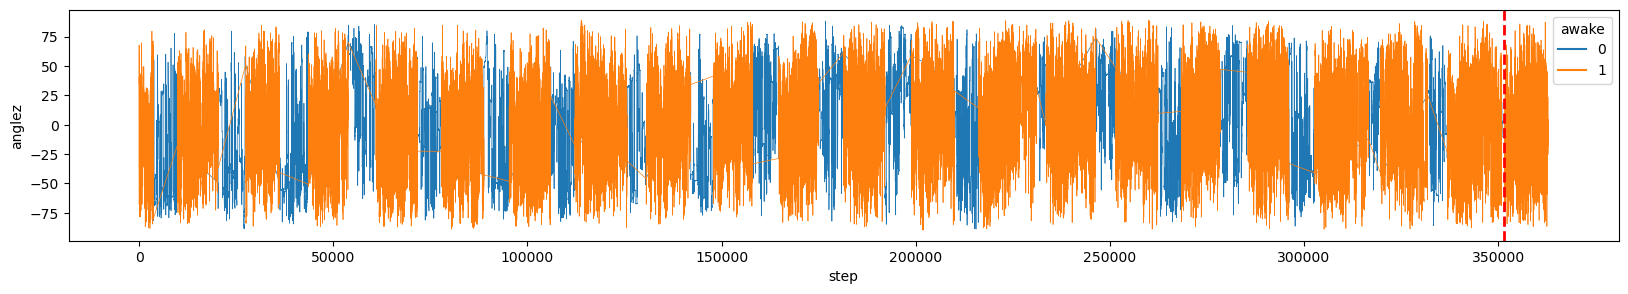

In [22]:
# Specific steps with missing values
from IPython.display import Markdown
before, after  = missing_step_info(events_1)
missing_steps = before + after  # Adjust this list with the actual step indices where missing values exist
missing_steps = [x for x in missing_steps if x is not None]

# Display Markdown
display(Markdown('### anglez for series ' + percent_5_missing[0]))

# Create the plot
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=train_1, x="step", y="anglez", hue="awake", linewidth=0.5)

# Highlight the specific steps in red
for step in missing_steps:
    ax.axvline(x=step, color='red', linestyle='--', linewidth=2)

plt.show()

In [23]:
series_2 = train_series[train_series.series_id == percent_5_missing[1]]
events_2 = train_events[train_events.series_id == percent_5_missing[1]]


In [24]:
events_2

,series_id,night,event,step,timestamp,year,month,day,hour,awake
1366,154fe824ed87,1,onset,5652.0,2019-01-26 22:21:00,2019.0,1.0,26.0,22.0,1
1367,154fe824ed87,1,wakeup,13224.0,2019-01-27 08:52:00,2019.0,1.0,27.0,8.0,0
1368,154fe824ed87,2,onset,24312.0,2019-01-28 00:16:00,2019.0,1.0,28.0,0.0,1
1369,154fe824ed87,2,wakeup,30996.0,2019-01-28 09:33:00,2019.0,1.0,28.0,9.0,0
1370,154fe824ed87,3,onset,41220.0,2019-01-28 23:45:00,2019.0,1.0,28.0,23.0,1
...,...,...,...,...,...,...,...,...,...,...
1425,154fe824ed87,30,wakeup,514980.0,2019-02-25 09:45:00,2019.0,2.0,25.0,9.0,0
1426,154fe824ed87,31,onset,525012.0,2019-02-25 23:41:00,2019.0,2.0,25.0,23.0,1
1427,154fe824ed87,31,wakeup,532260.0,2019-02-26 09:45:00,2019.0,2.0,26.0,9.0,0
1428,154fe824ed87,32,onset,NaN,NaT,NaN,NaN,NaN,NaN,1


In [25]:
# write a function to check if the missing values exists at the beigining or in th end 
def print_missing_index(df):
    missing_indices = df[df['step'].isna()].index
    for index in missing_indices:
        print(f'Missing index: {index}')
        


In [26]:
print_missing_index(events_2)

Missing index: 1424
Missing index: 1428
Missing index: 1429


In [27]:
events_2

,series_id,night,event,step,timestamp,year,month,day,hour,awake
1366,154fe824ed87,1,onset,5652.0,2019-01-26 22:21:00,2019.0,1.0,26.0,22.0,1
1367,154fe824ed87,1,wakeup,13224.0,2019-01-27 08:52:00,2019.0,1.0,27.0,8.0,0
1368,154fe824ed87,2,onset,24312.0,2019-01-28 00:16:00,2019.0,1.0,28.0,0.0,1
1369,154fe824ed87,2,wakeup,30996.0,2019-01-28 09:33:00,2019.0,1.0,28.0,9.0,0
1370,154fe824ed87,3,onset,41220.0,2019-01-28 23:45:00,2019.0,1.0,28.0,23.0,1
...,...,...,...,...,...,...,...,...,...,...
1425,154fe824ed87,30,wakeup,514980.0,2019-02-25 09:45:00,2019.0,2.0,25.0,9.0,0
1426,154fe824ed87,31,onset,525012.0,2019-02-25 23:41:00,2019.0,2.0,25.0,23.0,1
1427,154fe824ed87,31,wakeup,532260.0,2019-02-26 09:45:00,2019.0,2.0,26.0,9.0,0
1428,154fe824ed87,32,onset,NaN,NaT,NaN,NaN,NaN,NaN,1


In [78]:
events_2

,series_id,night,event,step,timestamp,year,month,day,hour,awake
1366,154fe824ed87,1,onset,5652.0,2019-01-26 22:21:00,2019.0,1.0,26.0,22.0,1
1367,154fe824ed87,1,wakeup,13224.0,2019-01-27 08:52:00,2019.0,1.0,27.0,8.0,0
1368,154fe824ed87,2,onset,24312.0,2019-01-28 00:16:00,2019.0,1.0,28.0,0.0,1
1369,154fe824ed87,2,wakeup,30996.0,2019-01-28 09:33:00,2019.0,1.0,28.0,9.0,0
1370,154fe824ed87,3,onset,41220.0,2019-01-28 23:45:00,2019.0,1.0,28.0,23.0,1
...,...,...,...,...,...,...,...,...,...,...
1425,154fe824ed87,30,wakeup,514980.0,2019-02-25 09:45:00,2019.0,2.0,25.0,9.0,0
1426,154fe824ed87,31,onset,525012.0,2019-02-25 23:41:00,2019.0,2.0,25.0,23.0,1
1427,154fe824ed87,31,wakeup,532260.0,2019-02-26 09:45:00,2019.0,2.0,26.0,9.0,0
1428,154fe824ed87,32,onset,NaN,NaT,NaN,NaN,NaN,NaN,1


In [90]:
import pandas as pd

def missing_step_info(df):
    non_missing_values = []

    missing_indices = df[df['step'].isna()].index

    for index in missing_indices:
        before_index = None
        after_index = None
        
        # Search for the nearest non-null value before the missing 'step'
        for i in range(index - 1, -1, -1):
            if i in df.index and not pd.isna(df.at[i, 'step']):
                before_index = i
                break

        # Search for the nearest non-null value after the missing 'step'
        for i in range(index + 1, df.index[-1]):
            if i in df.index and not pd.isna(df.at[i, 'step']):
                after_index = i
                break

        before_step = df.at[before_index, 'step'] if before_index is not None else None
        after_step = df.at[after_index, 'step'] if after_index is not None else None
        
        non_missing_values.append((before_step, after_step))
        
    return non_missing_values



In [29]:
# we have two missing values in the end can be ignored, but we need to check 1424
series_2.head(10)

,series_id,step,timestamp,anglez,enmo
12896280,154fe824ed87,0.0,2019-01-26 14:30:00,28.432400,0.0245
12896281,154fe824ed87,1.0,2019-01-26 14:30:05,28.131001,0.0206
12896282,154fe824ed87,2.0,2019-01-26 14:30:10,28.391001,0.0324
12896283,154fe824ed87,3.0,2019-01-26 14:30:15,27.163900,0.0325
12896284,154fe824ed87,4.0,2019-01-26 14:30:20,27.102501,0.0385
12896285,154fe824ed87,5.0,2019-01-26 14:30:25,25.534599,0.0281
12896286,154fe824ed87,6.0,2019-01-26 14:30:30,24.661800,0.0257
12896287,154fe824ed87,7.0,2019-01-26 14:30:35,28.084499,0.0173
12896288,154fe824ed87,8.0,2019-01-26 14:30:40,28.193701,0.0162
12896289,154fe824ed87,9.0,2019-01-26 14:30:45,27.955200,0.0164


In [30]:
train_2 = pd.merge(series_2, events_2[['step','awake']], on='step', how='left')
train_2["awake"] = train_2["awake"].bfill(axis ='rows')
# final section:
# train_events.groupby('series_id').tail(1)["event"].unique()
# Result: the last event is always a "wakeup"
train_2['awake'] = train_2['awake'].fillna(1) # awake
train_2["awake"] = train_2["awake"].astype("int")

In [20]:
train_2

,series_id,step,timestamp,anglez,enmo,awake
0,154fe824ed87,0.0,2019-01-26 14:30:00,28.432400,0.0245,1
1,154fe824ed87,1.0,2019-01-26 14:30:05,28.131001,0.0206,1
2,154fe824ed87,2.0,2019-01-26 14:30:10,28.391001,0.0324,1
3,154fe824ed87,3.0,2019-01-26 14:30:15,27.163900,0.0325,1
4,154fe824ed87,4.0,2019-01-26 14:30:20,27.102501,0.0385,1
...,...,...,...,...,...,...
552235,154fe824ed87,552235.0,2019-02-27 13:29:35,-6.037700,0.0000,1
552236,154fe824ed87,552236.0,2019-02-27 13:29:40,-6.037700,0.0000,1
552237,154fe824ed87,552237.0,2019-02-27 13:29:45,-6.037700,0.0008,1
552238,154fe824ed87,552238.0,2019-02-27 13:29:50,-5.872100,0.0073,1


### anglez for series 154fe824ed87

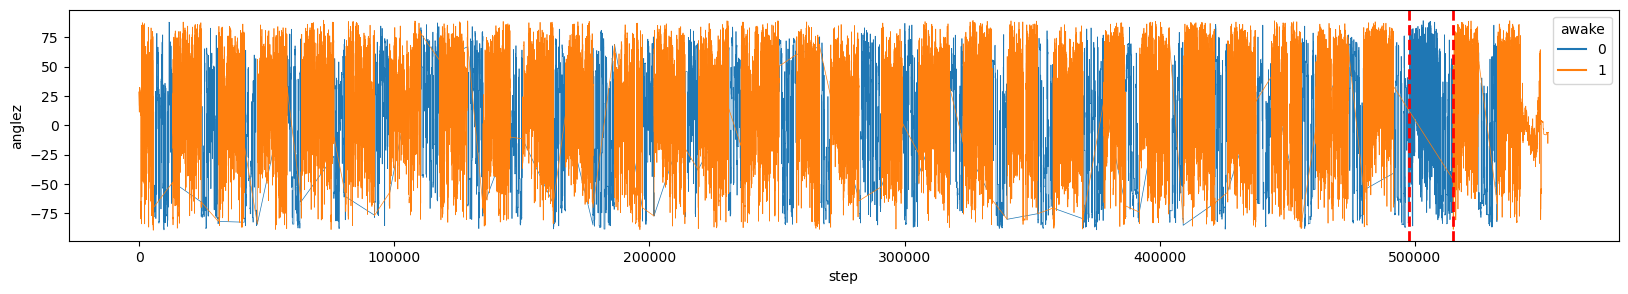

In [31]:
# Specific steps with missing values
from IPython.display import Markdown
before, after  = missing_step_info(events_2)
missing_steps = before + after  # Adjust this list with the actual step indices where missing values exist

# Display Markdown
display(Markdown('### anglez for series ' + percent_5_missing[1]))

# Create the plot
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=train_2, x="step", y="anglez", hue="awake", linewidth=0.5)

# Highlight the specific steps in red
for step in missing_steps:
    ax.axvline(x=step, color='red', linestyle='--', linewidth=2)

plt.show()

functionalize this process for all 5% missing series

In [96]:
def get_train_series(series):
    series = train_series[train_series.series_id == series]
    events = train_events[train_events.series_id == series]

    train = pd.merge(series, events[['step','awake']], on='step', how='left')
    train["awake"] = train["awake"].bfill(axis ='rows')
    # final section:
    # train_events.groupby('series_id').tail(1)["event"].unique()
    # Result: the last event is always a "wakeup"
    train['awake'] = train['awake'].fillna(1) # awake
    train["awake"] = train["awake"].astype("int")
    return(train)

# Plots

[351624.0]


### anglez for series 0ef7d94fde99

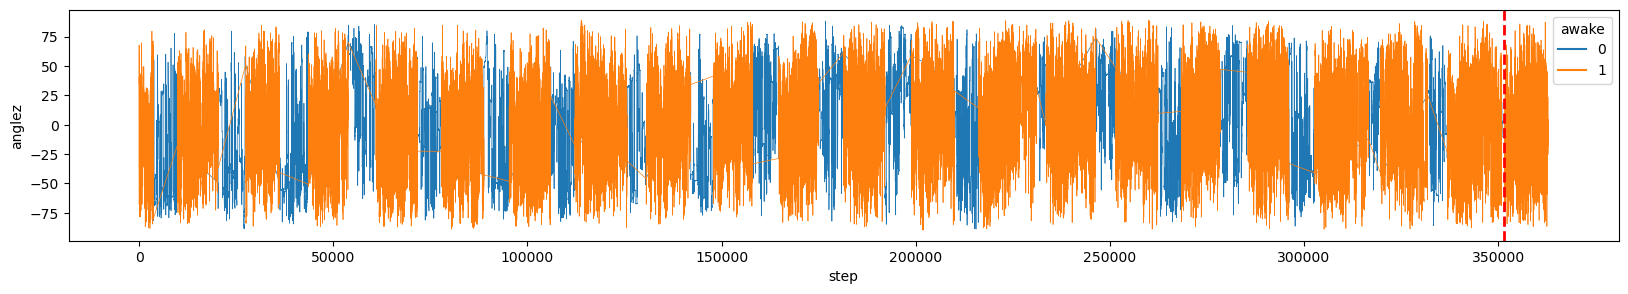

[497832.0, 514980.0, 532260.0]


### anglez for series 154fe824ed87

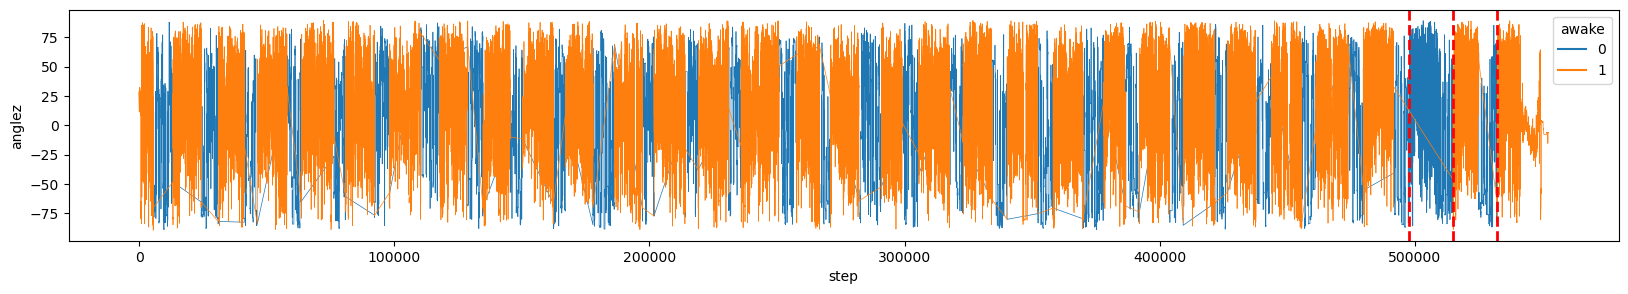

[148488.0, 177300.0]


### anglez for series 188d4b7cd28b

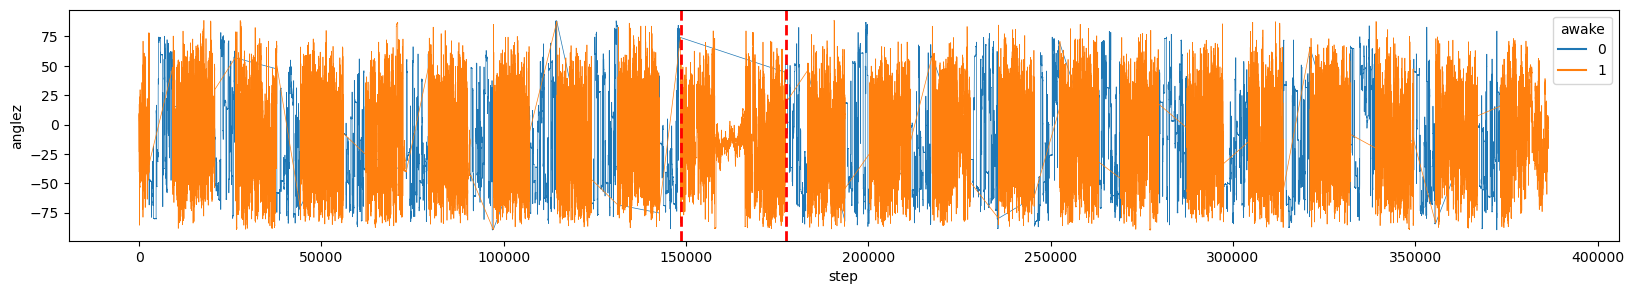

[199620.0, 169812.0]


### anglez for series 1b92be89db4c

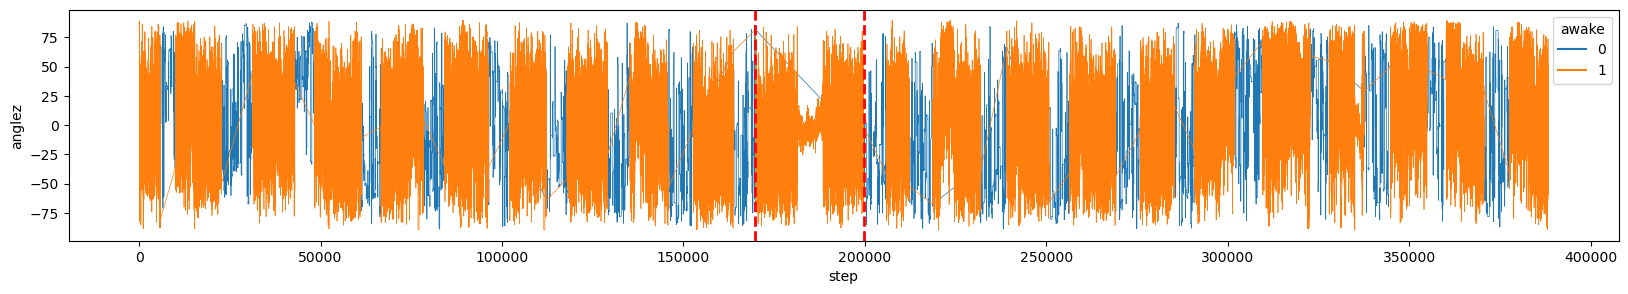

[17676.0, 45084.0]


### anglez for series 27f09a6a858f

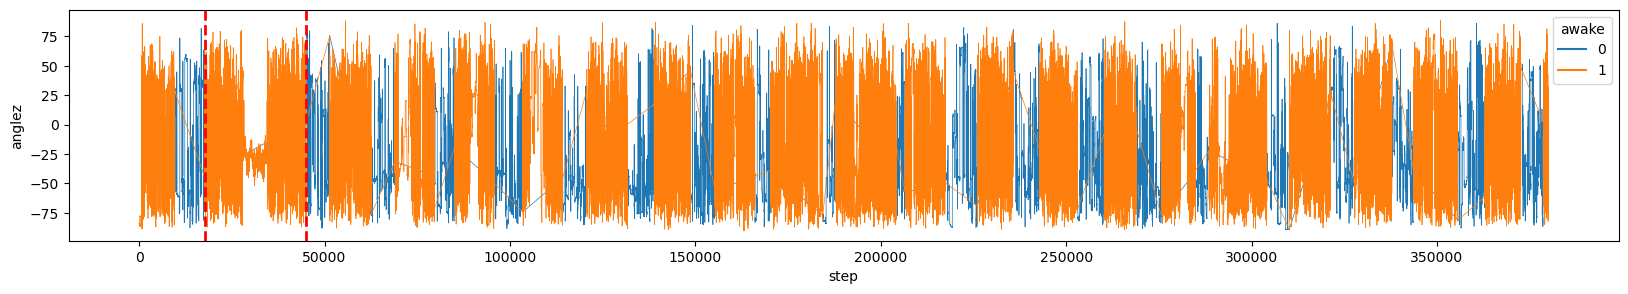

[189852.0, 216372.0]


### anglez for series 449766346eb1

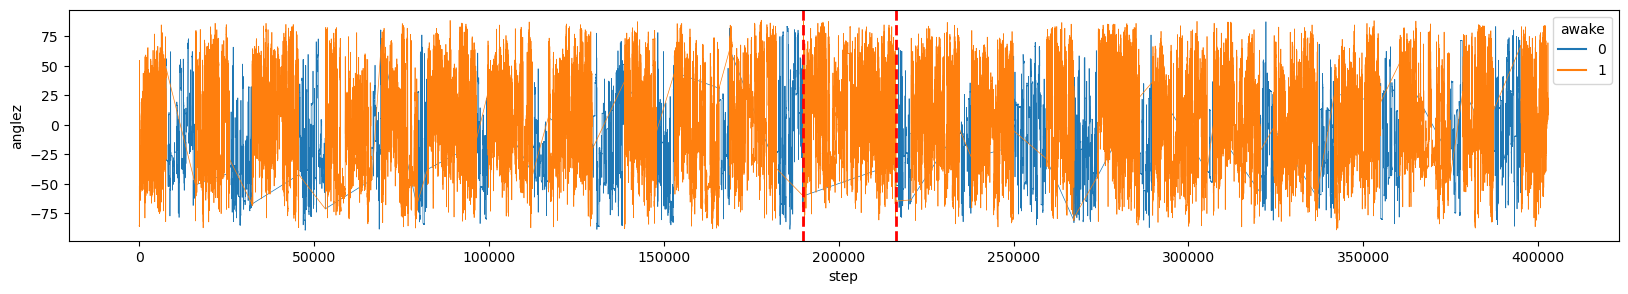

[340632.0, 370236.0]


### anglez for series 4ab54be1a403

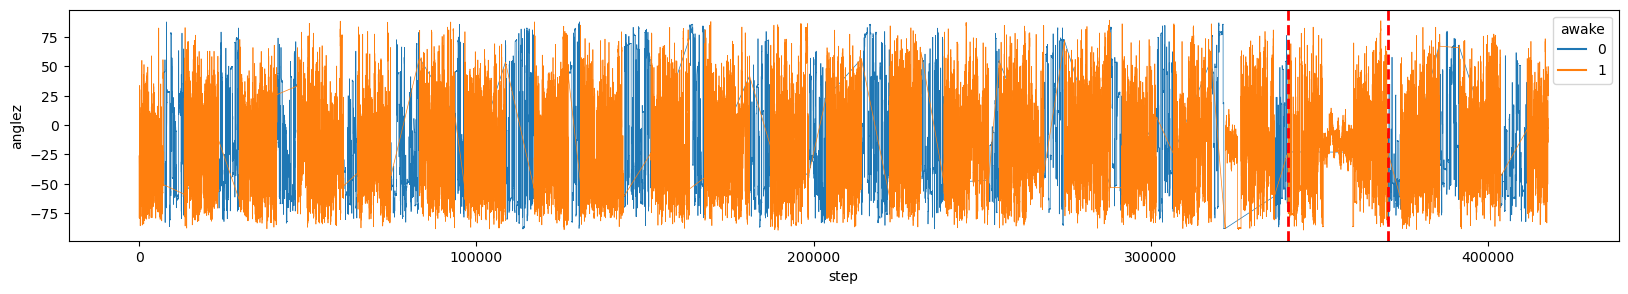

[111912.0, 86076.0]


### anglez for series 51b23d177971

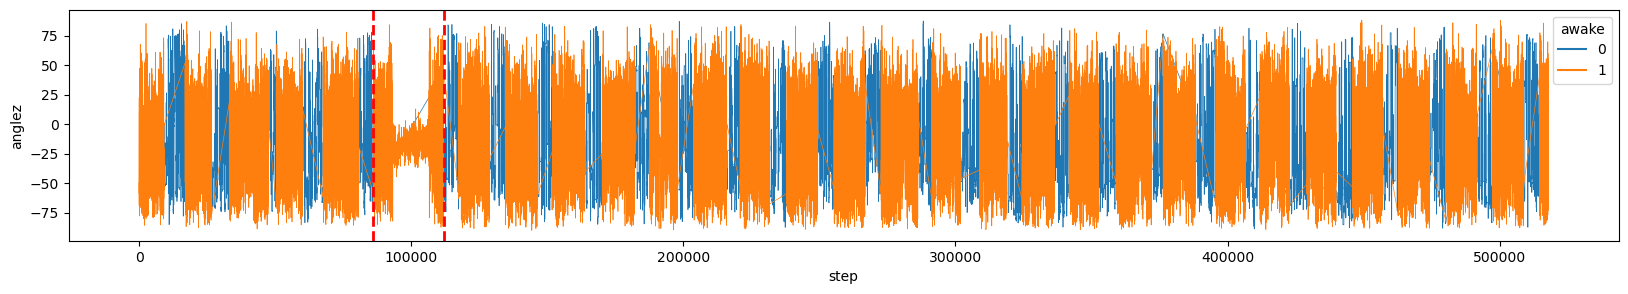

[284400.0, 256236.0]


### anglez for series 5f76965e10cf

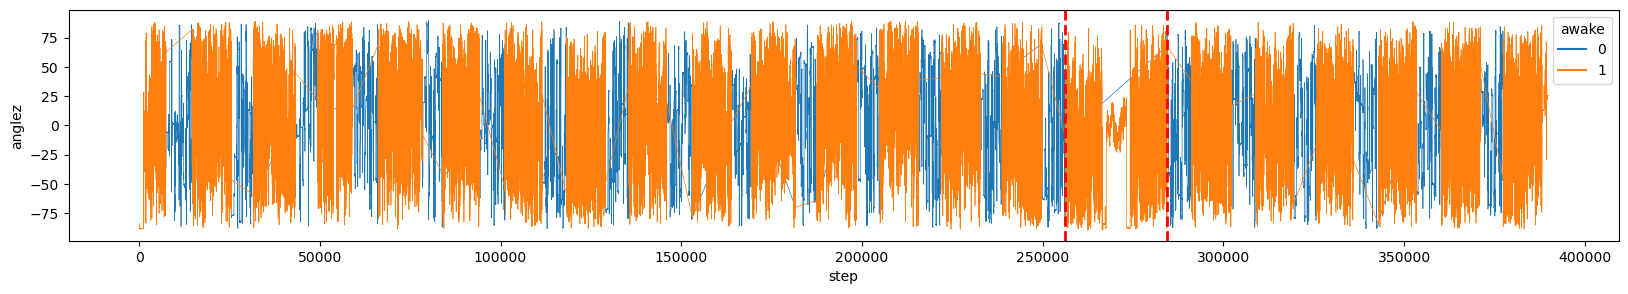

[141336.0, 111444.0]


### anglez for series 653622ac8363

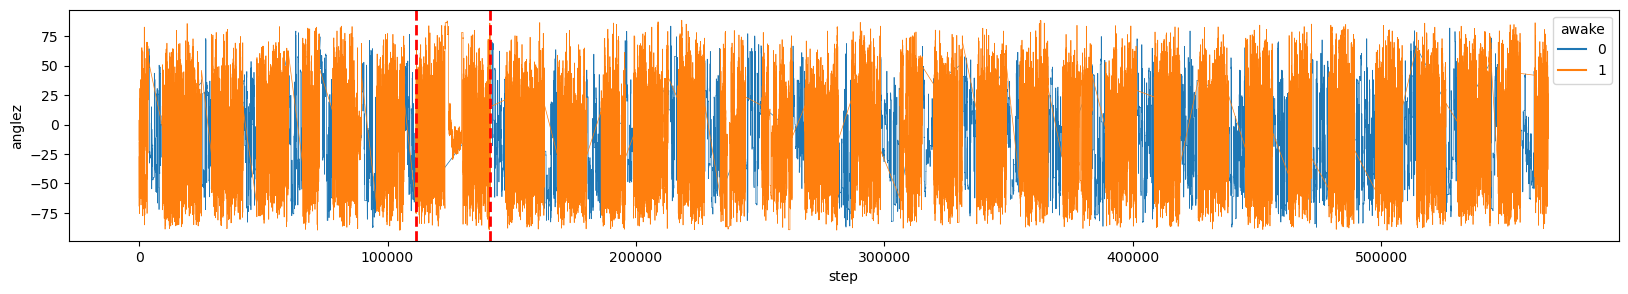

[355224.0]


### anglez for series 752900afe3a6

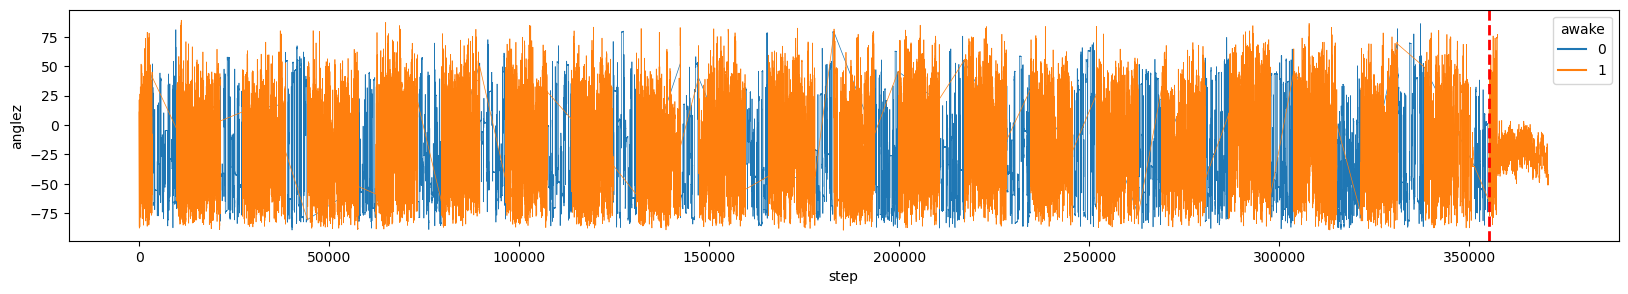

[8448.0, 37932.0]


### anglez for series 7df249527c63

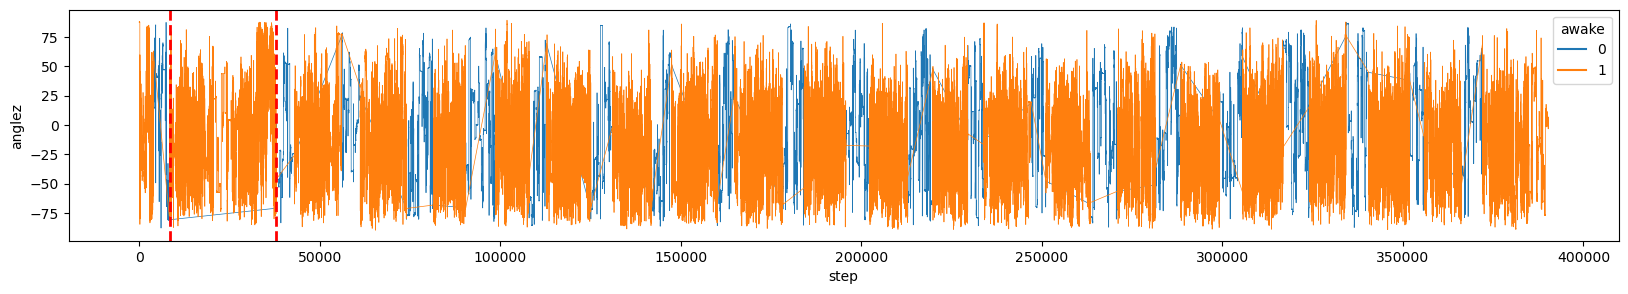

[391752.0]


### anglez for series 804594bb1f06

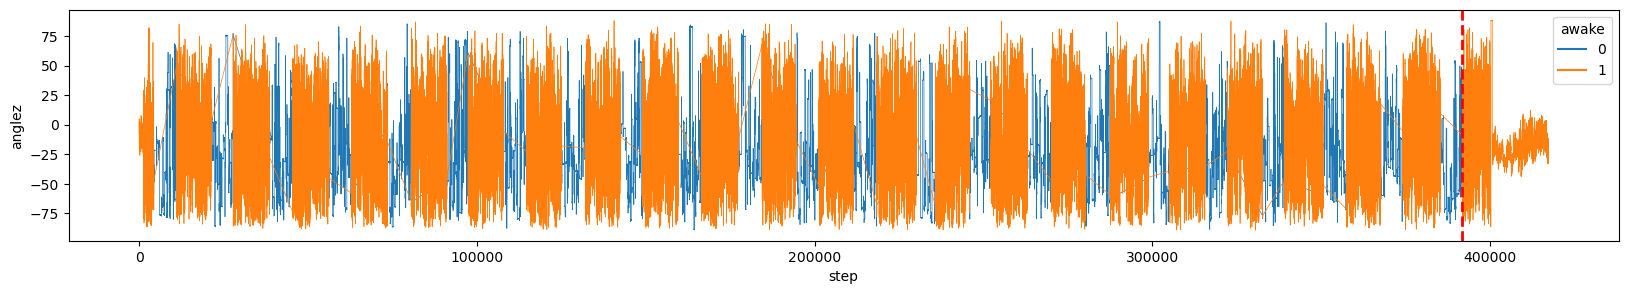

[184848.0, 212736.0]


### anglez for series 8877a6586606

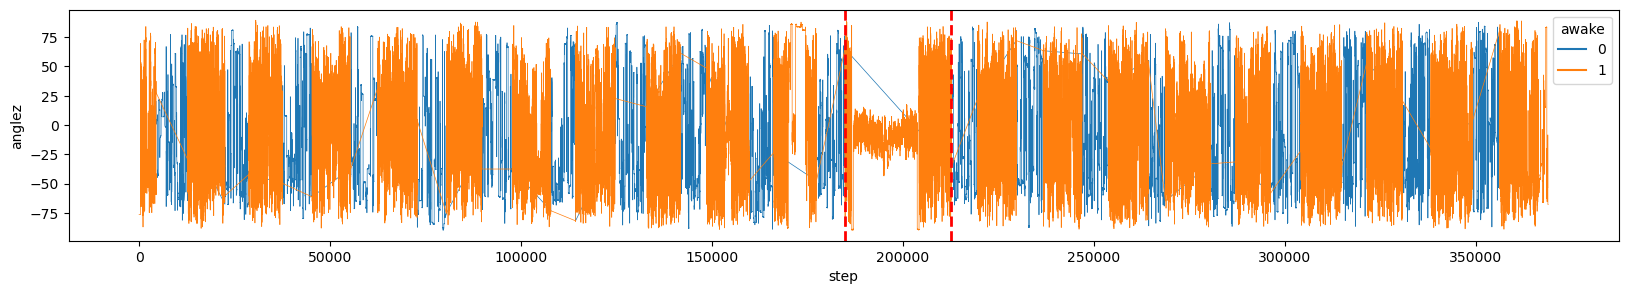

[390324.0]


### anglez for series 8a306e0890c0

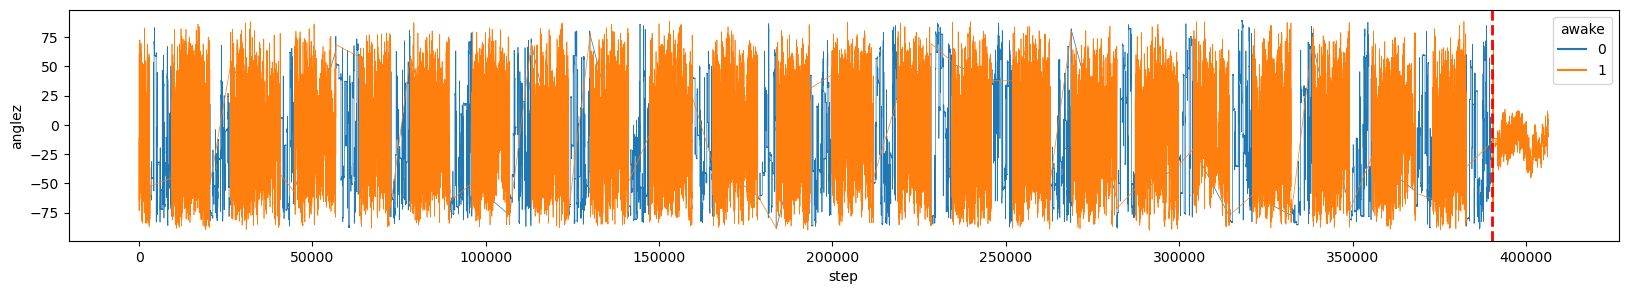

[372252.0]


### anglez for series 8fb18e36697d

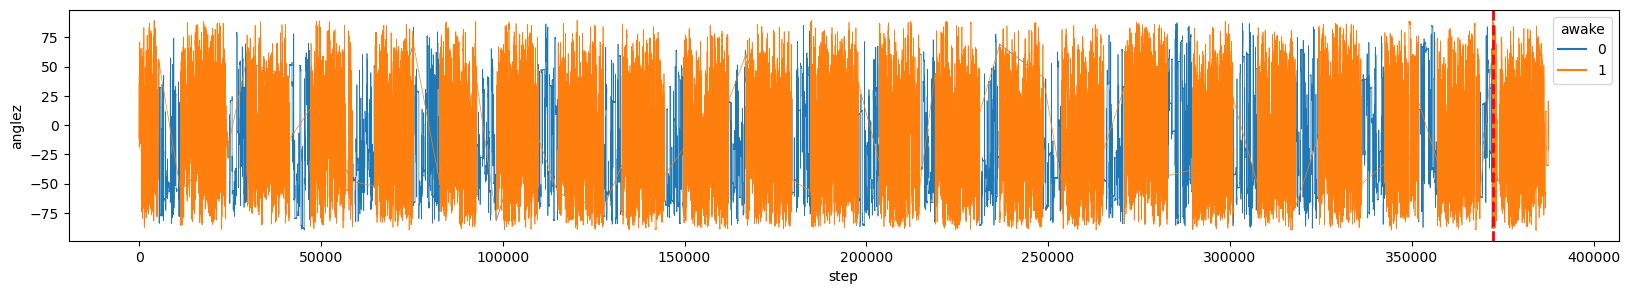

[392976.0]


### anglez for series 91cb6c98201f

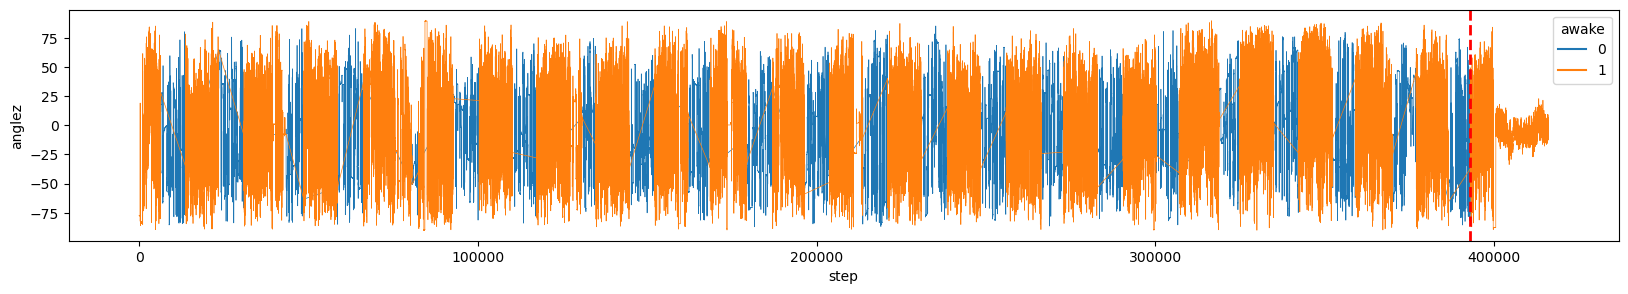

[394284.0]


### anglez for series 99237ce045e4

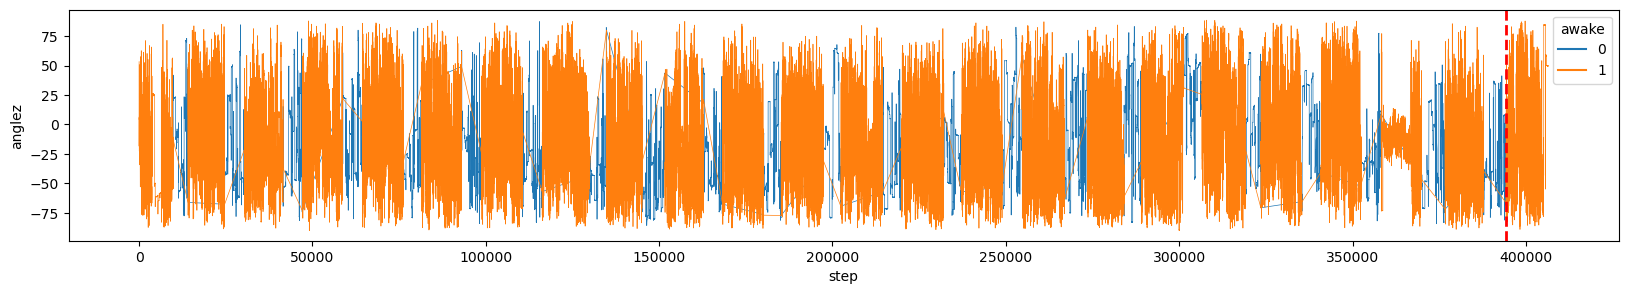

[25056.0, 55812.0]


### anglez for series bdfce9ce62b9

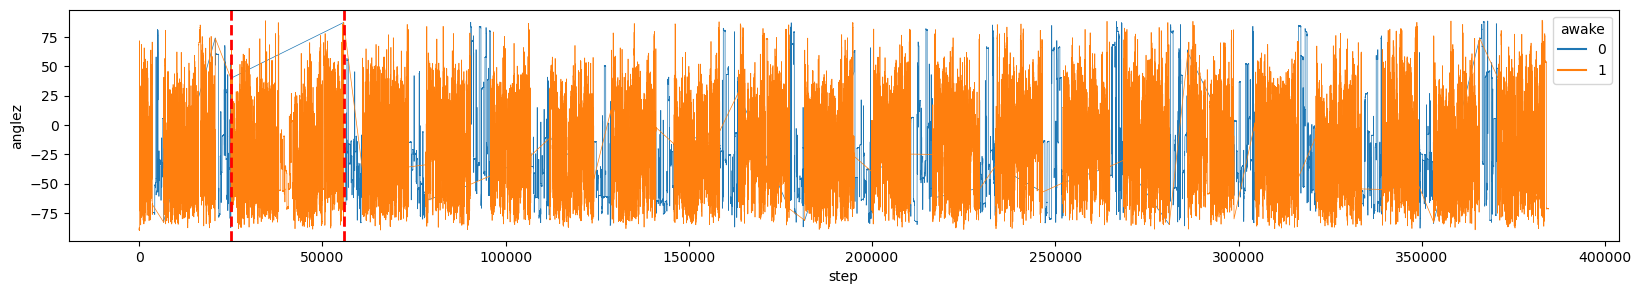

[376632.0]


### anglez for series bfe41e96d12f

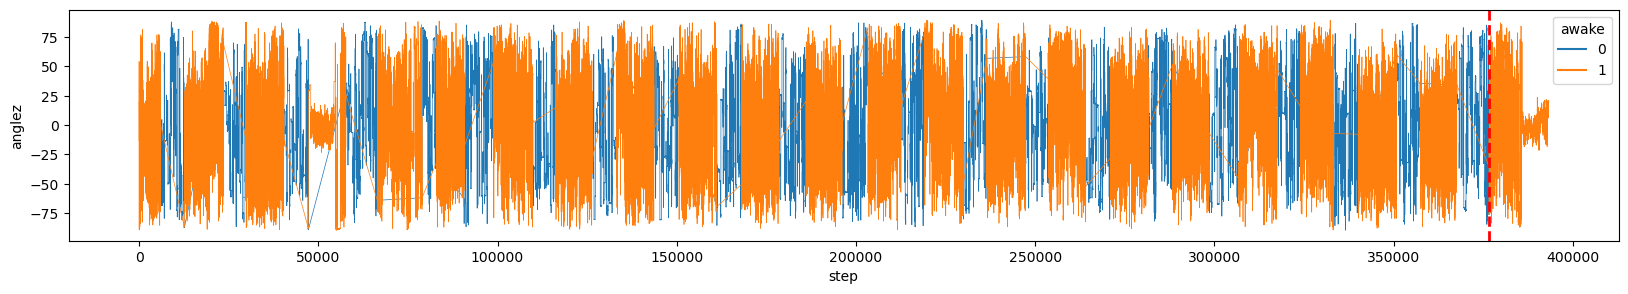

[27804.0]


### anglez for series d93b0c7de16b

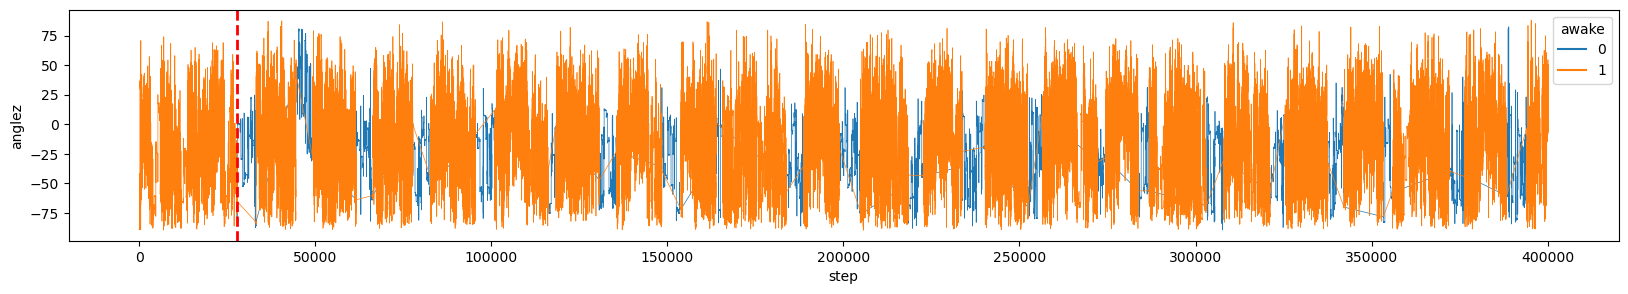

[549000.0]


### anglez for series e8d0a37c3eba

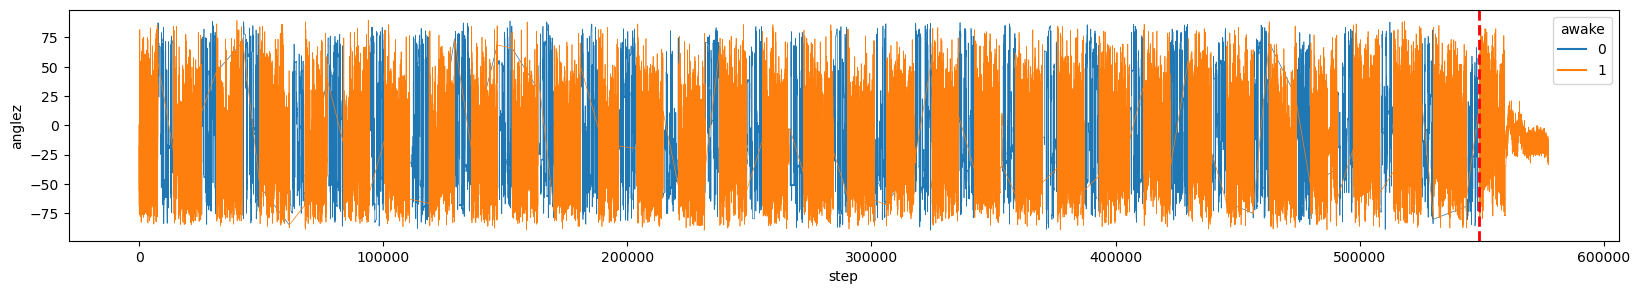

[25152.0]


### anglez for series f6d2cc003183

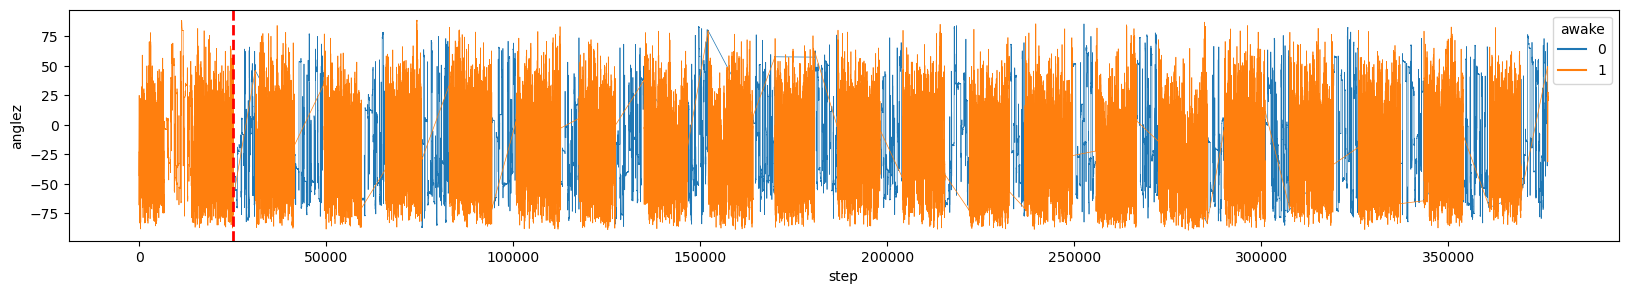

[376692.0]


### anglez for series f7eb179216c2

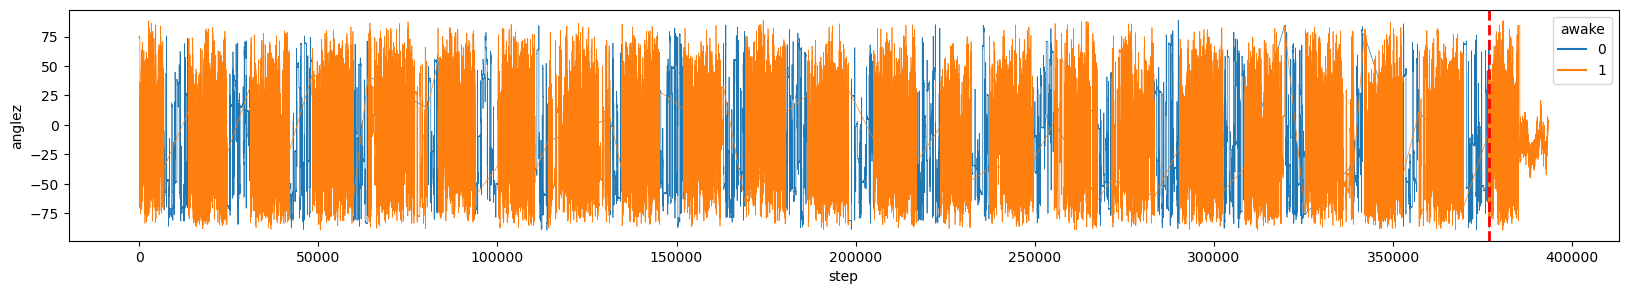

[602136.0]


### anglez for series fcca183903b7

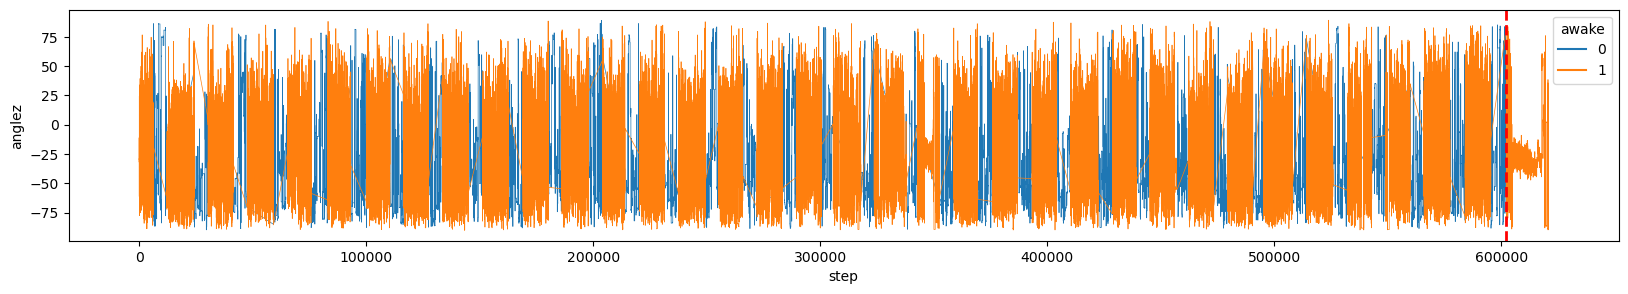

In [91]:
for series_id in percent_5_missing:
    
    series = train_series[train_series.series_id == series_id]   
    #train = get_train_series(series_id)
    events = train_events[train_events.series_id == series_id]
    
    train = pd.merge(series, events[['step','awake']], on='step', how='left')
    train["awake"] = train["awake"].bfill(axis ='rows')
    
    # final section:
    # train_events.groupby('series_id').tail(1)["event"].unique()
    # Result: the last event is always a "wakeup"
    train['awake'] = train['awake'].fillna(1) # awake
    train["awake"] = train["awake"].astype("int")

    
    # Specific steps with missing values
    # missing steps index is the non missing step one index before and after the missing index
    
    result= missing_step_info(events)
    
    # Flatten the list of pairs and remove duplicates
    unique_values = set(value for pair in result for value in pair if value is not None)

    # Convert the unique values back to a list if needed
    missing_steps = list(unique_values)

    print(missing_steps)
    
    # Display Markdown
    display(Markdown('### anglez for series ' + series_id))

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=train, x="step", y="anglez", hue="awake", linewidth=0.5)

    # Highlight the specific steps in red
    for step in missing_steps:
        ax.axvline(x=step, color='red', linestyle='--', linewidth=2)

    plt.show()
    del train
    gc.collect();

0ef7d94fde99 [42 43] 44
154fe824ed87 [58 62 63] 64
188d4b7cd28b [18 19] 44
1b92be89db4c [20 21] 44
27f09a6a858f [2 3] 44
449766346eb1 [22 23] 46
4ab54be1a403 [40 41] 48
51b23d177971 [10 11] 60
5f76965e10cf [30 31] 44
653622ac8363 [14 15] 66
752900afe3a6 [42 43] 44
7df249527c63 [2 3] 44
804594bb1f06 [46 47] 48
8877a6586606 [22 23] 42
8a306e0890c0 [46 47] 48
8fb18e36697d [44 45] 46
91cb6c98201f [46 47] 48
99237ce045e4 [46 47] 48
bdfce9ce62b9 [4 5] 44
bfe41e96d12f [44 45] 46
d93b0c7de16b [0 1] 46
e8d0a37c3eba [64 65] 66
f6d2cc003183 [0 1] 44
f7eb179216c2 [44 45] 46
fcca183903b7 [70 71] 72

In [ ]:
# now try to update series 


In [93]:
type_a = ['0ef7d94fde99', '154fe824ed87', '752900afe3a6', '804594bb1f06', '8a306e0890c0', '8fb18e36697d', '91cb6c98201f', '99237ce045e4','bfe41e96d12f', 'e8d0a37c3eba','f7eb179216c2','fcca183903b7']
type_b = ['27f09a6a858f', '7df249527c63', 'bdfce9ce62b9', 'd93b0c7de16b', 'f6d2cc003183']

In [132]:
def drop_after_na(series_id):
    
    series = train_series[train_series.series_id == series_id]   
    events = train_events[train_events.series_id == series_id]

    train = pd.merge(series, events[['step','awake']], on='step', how='left')
    train["awake"] = train["awake"].bfill(axis ='rows')

    train['awake'] = train['awake'].fillna(1) # awake
    train["awake"] = train["awake"].astype("int")
    print('train shape', train.shape)

    missing_index = missing_indices = events[events['step'].isna()].index
    cut_step = events.at[missing_indices[0]-1, 'step']
    train = train.reset_index(drop=True)
    index = train.loc[train['step'] == cut_step].index[0]
    processed_train = train.loc[train.index<= index]

    print('processed shape', processed_train.shape)
    return(processed_train )

In [133]:
drop_after_na(type_a[0])

train shape (362880, 6)
processed shape (351625, 6)


,series_id,step,timestamp,anglez,enmo,awake
0,0ef7d94fde99,0.0,2018-01-26 17:30:00,34.612598,0.0266,1
1,0ef7d94fde99,1.0,2018-01-26 17:30:05,47.057598,0.0277,1
2,0ef7d94fde99,2.0,2018-01-26 17:30:10,62.150902,0.0205,1
3,0ef7d94fde99,3.0,2018-01-26 17:30:15,67.852699,0.0312,1
4,0ef7d94fde99,4.0,2018-01-26 17:30:20,66.735497,0.0306,1
...,...,...,...,...,...,...
351620,0ef7d94fde99,351620.0,2018-02-16 01:51:40,-10.071800,0.0000,0
351621,0ef7d94fde99,351621.0,2018-02-16 01:51:45,-9.892700,0.0000,0
351622,0ef7d94fde99,351622.0,2018-02-16 01:51:50,-10.091100,0.0000,0
351623,0ef7d94fde99,351623.0,2018-02-16 01:51:55,-10.104900,0.0000,0


In [134]:
def drop_before_na(series_id):
    series = train_series[train_series.series_id == series_id]
    events = train_events[train_events.series_id == series_id]

    train = pd.merge(series, events[['step', 'awake']], on='step', how='left')
    train['awake'] = train['awake'].bfill(axis='rows')

    train['awake'] = train['awake'].fillna(1)  # awake
    train['awake'] = train['awake'].astype(int)
    print('train shape', train.shape)

    missing_indices = events[events['step'].isna()].index

    # Adjust the index range to include part before and NA values
    start_index = missing_indices[0] if len(missing_indices) > 0 else 0
    train = train.reset_index(drop=True)
    processed_train = train.loc[train.index >= start_index]

    print('processed shape', processed_train.shape)
    return processed_train

In [135]:
drop_before_na(type_b[0])

train shape (379980, 6)
processed shape (377708, 6)


,series_id,step,timestamp,anglez,enmo,awake
2272,27f09a6a858f,2272.0,2018-07-31 13:39:20,40.078300,0.0490,1
2273,27f09a6a858f,2273.0,2018-07-31 13:39:25,38.237598,0.0453,1
2274,27f09a6a858f,2274.0,2018-07-31 13:39:30,36.996899,0.0311,1
2275,27f09a6a858f,2275.0,2018-07-31 13:39:35,33.092701,0.0402,1
2276,27f09a6a858f,2276.0,2018-07-31 13:39:40,32.003700,0.0329,1
...,...,...,...,...,...,...
379975,27f09a6a858f,379975.0,2018-08-22 10:14:35,-42.926102,0.0097,1
379976,27f09a6a858f,379976.0,2018-08-22 10:14:40,-45.860199,0.0071,1
379977,27f09a6a858f,379977.0,2018-08-22 10:14:45,-14.779700,0.0214,1
379978,27f09a6a858f,379978.0,2018-08-22 10:14:50,-25.073999,0.0017,1
